In [3]:
import matplotlib.pyplot as plt
from src.models import *
from src.model_analysis.utils import same_output
from src.post_quant.cle import cle_for_resmlp
from src.post_quant.bias_absorb import ba_for_resmlp
from src.model_analysis.visualize import layer_dist, act_dist, simulate_input, scale_plot, add_value_labels

# org_model = resmlp_24(pretrained=False).cuda().eval()
model = resmlp_24(pretrained=False).eval()
model.load_state_dict(torch.load("ResMLP_S24_ReLU_fp32_80.602.pth"))

model_norm = resmlp_24_norm(pretrained=False).eval()
model_norm.load_state_dict(torch.load("resmlp_norm.pth")["model"])
# qmodel = q_resmlp(model)

<All keys matched successfully>

In [2]:
# test CLE
model = resmlp_24(pretrained=True).eval()
cle_for_resmlp(model)
print(same_output(model, org_model, eps=1e-5))

True


NameError: name 'get_linear_layers' is not defined

RuntimeError: The size of tensor a (384) must match the size of tensor b (196) at non-singleton dimension 0

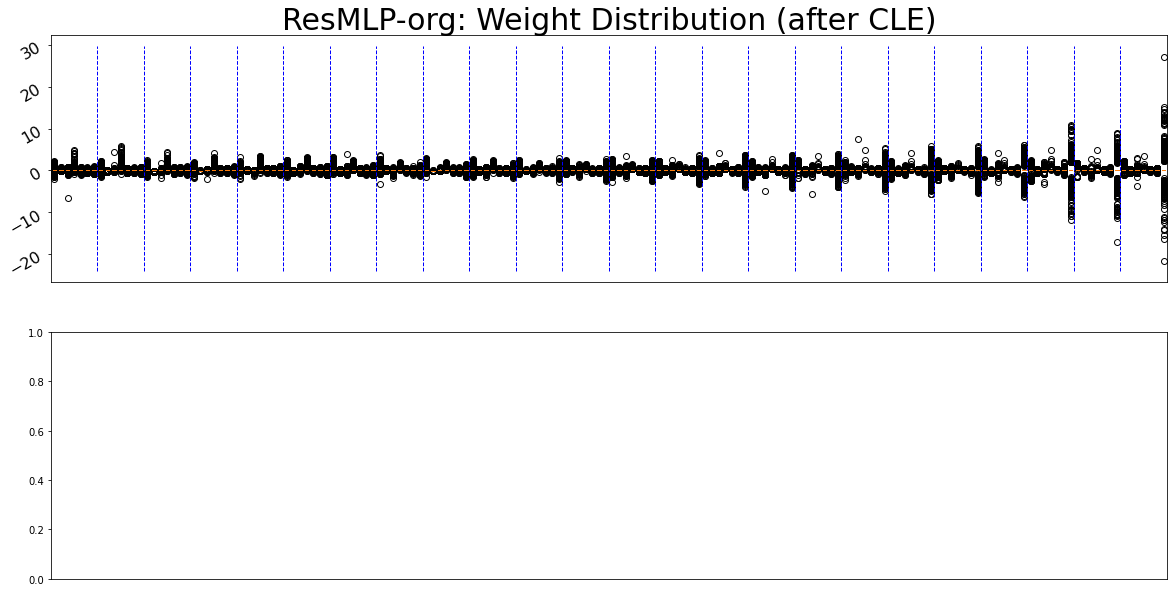

In [7]:
model = resmlp_24(pretrained=True).eval()
model_norm = resmlp_24_norm(pretrained=True).eval()
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

# cle_for_resmlp(model)
layer_dist(model, 0, 23, name="ResMLP-org: Weight Distribution (after CLE)", ax=ax[0])
# cle_for_resmlp(model)
# res_
cle_for_resmlp(model_norm)
layer_dist(model_norm, 0, 23, name="ResMLP-BN: Weight Distribution (before CLE)", ax=ax[1])

Loading a small piece of training data...
Calibrating...
Calibrate: [ 0/21]	Time  9.728 ( 9.728)
Calibrate: [10/21]	Time  2.104 ( 2.849)
Calibrate: [20/21]	Time  0.298 ( 2.415)
Loading a small piece of training data...
Calibrating...
Calibrate: [ 0/21]	Time  9.120 ( 9.120)
Calibrate: [10/21]	Time  1.662 ( 2.354)
Calibrate: [20/21]	Time  0.258 ( 1.952)


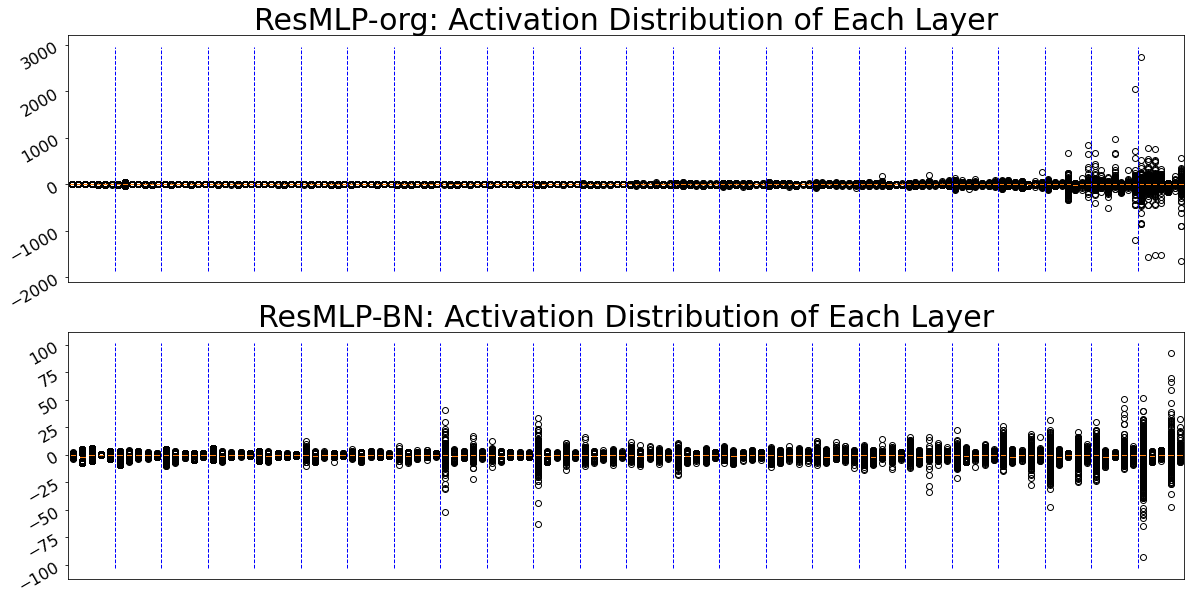

In [10]:
model = resmlp_24(pretrained=True).cuda().eval()
model_norm = resmlp_24_norm(pretrained=True).cuda().eval()
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

act_dist(model, 0, 23, name='ResMLP-org: Activation Distribution of Each Layer', ax=ax[0], real_sim=True)
act_dist(model_norm, 0, 23, name='ResMLP-BN: Activation Distribution of Each Layer', ax=ax[1], real_sim=True)

In [ ]:
model = resmlp_24(pretrained=True).eval()
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

act_dist(model_norm, 0, 23, name='ResMLP-BN: Activation Distribution of Each Layer', ax=ax[0])

act_dist(model_norm, 0, 23, name='ResMLP-BN: Activation Distribution of Each Layer (without attn)', show_layers=["mlp.fc1", "mlp.fc2"], ax=ax[1])

In [ ]:
model = resmlp_24(pretrained=True).eval()
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

act_dist(model, 0, 23, name='Activation Distribution of Each Layer', ax=ax[0])

act_dist(model_norm, 0, 23, name='ResMLP-BN: Activation Distribution of Each Layer', ax=ax[1])

In [25]:
# ckp = torch.load("./resmlp_norm2.pth", map_location='cpu')["model"]
# modified_dict = {}
# for k, v in ckp.items():
#     # if "norm" in k:
#     #     # print(k)
#     #     if ("weight" in k) or ("bias" in k):
#     #         continue
#     modified_dict[k] = v

# _ = model_norm.load_state_dict(ckp, strict=False)

checkpoint = torch.load("./resmlp_norm2.pth", map_location='cpu')["model"]
_ = model_norm.load_state_dict(checkpoint, strict=False)

In [22]:
model_norm = resmlp_24_norm(pretrained=True).eval()

In [29]:
import torchsummary as summary
summary.summary(model, (3, 224, 224), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 384, 14, 14]         295,296
          Identity-2             [-1, 196, 384]               0
        PatchEmbed-3             [-1, 196, 384]               0
            Linear-4             [-1, 196, 384]         147,840
            Linear-5             [-1, 384, 196]          38,612
            Linear-6             [-1, 196, 384]         147,456
          Identity-7             [-1, 196, 384]               0
          Identity-8             [-1, 196, 384]               0
            Linear-9             [-1, 196, 384]         147,840
           Linear-10            [-1, 196, 1536]         591,360
             ReLU-11            [-1, 196, 1536]               0
          Dropout-12            [-1, 196, 1536]               0
           Linear-13             [-1, 196, 384]         590,208
          Dropout-14             [-1, 1

In [28]:
import torchsummary as summary
summary.summary(model_norm, (3, 224, 224), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 384, 14, 14]         295,296
          Identity-2             [-1, 196, 384]               0
        PatchEmbed-3             [-1, 196, 384]               0
       BatchNorm1d-4             [-1, 196, 384]             392
            Linear-5             [-1, 384, 196]          38,612
            Linear-6             [-1, 196, 384]         147,456
          Identity-7             [-1, 196, 384]               0
       BatchNorm1d-8             [-1, 196, 384]             392
            Linear-9            [-1, 196, 1536]         591,360
             ReLU-10            [-1, 196, 1536]               0
          Dropout-11            [-1, 196, 1536]               0
           Linear-12             [-1, 196, 384]         590,208
          Dropout-13             [-1, 196, 384]               0
              Mlp-14             [-1, 1

In [30]:
# getattr(model, f"layer0")
b_temp = None
for i in range(1):
    for n, m in model_norm.blocks[i].named_modules():
        print(n)
        if "norm1" in n:
            b_temp = m
            # n_parameters = sum(p.numel() for p in m.parameters() if p.requires_grad)
            # print(n_parameters)


norm1
attn
drop_path
norm2
mlp
mlp.fc1
mlp.act
mlp.drop1
mlp.fc2
mlp.drop2
gamma_1
gamma_2


In [26]:
model_norm.blocks[0].gamma_2.weight.shape

torch.Size([384, 384])

In [3]:
b_temp.weight

Parameter containing:
tensor([0.9538, 0.9322, 0.9380, 0.9432, 0.9258, 0.9307, 0.9391, 0.9330, 0.9241,
        0.9519, 0.9571, 0.9361, 0.9451, 0.9403, 0.9387, 0.9308, 0.9309, 0.9416,
        0.9403, 0.9263, 0.9267, 0.9214, 0.9277, 0.9246, 0.9285, 0.9312, 0.9467,
        0.9389, 0.9280, 0.9300, 0.9372, 0.9290, 0.9278, 0.9042, 0.9085, 0.9365,
        0.9222, 0.9125, 0.9355, 0.9408, 0.9241, 0.9362, 0.9272, 0.9286, 0.9221,
        0.9176, 0.9297, 0.9312, 0.9107, 0.9057, 0.9113, 0.9024, 0.9207, 0.9208,
        0.9235, 0.9214, 0.9286, 0.9063, 0.9196, 0.9201, 0.9215, 0.9007, 0.9193,
        0.9011, 0.9099, 0.9120, 0.9128, 0.9272, 0.9265, 0.9142, 0.9299, 0.9329,
        0.9051, 0.8992, 0.9043, 0.9014, 0.9039, 0.9108, 0.9100, 0.9022, 0.9314,
        0.9156, 0.9197, 0.9236, 0.9272, 0.9133, 0.9077, 0.8995, 0.8989, 0.9044,
        0.8928, 0.9039, 0.9018, 0.9164, 0.8978, 0.9186, 0.9080, 0.9218, 0.9140,
        0.9128, 0.9264, 0.9021, 0.8960, 0.9053, 0.9153, 0.9017, 0.9114, 0.9069,
        0.9126, 0.

In [4]:
running_std = torch.sqrt(b_temp.running_var + b_temp.eps)
scale_factor = b_temp.weight / running_std
scale_factor

tensor([0.7023, 0.6825, 0.6790, 0.6797, 0.6602, 0.6504, 0.6635, 0.6589, 0.6528,
        0.6819, 0.6998, 0.6849, 0.7031, 0.7045, 0.6933, 0.6825, 0.6711, 0.6819,
        0.6778, 0.6522, 0.6646, 0.6663, 0.6691, 0.6768, 0.6826, 0.6858, 0.7099,
        0.7143, 0.6804, 0.6811, 0.6814, 0.6728, 0.6690, 0.6452, 0.6512, 0.6766,
        0.6636, 0.6648, 0.6912, 0.6953, 0.6768, 0.6975, 0.6740, 0.6700, 0.6618,
        0.6605, 0.6683, 0.6577, 0.6523, 0.6537, 0.6579, 0.6597, 0.6739, 0.6767,
        0.6705, 0.6793, 0.6799, 0.6569, 0.6637, 0.6668, 0.6689, 0.6346, 0.6638,
        0.6523, 0.6620, 0.6686, 0.6777, 0.6862, 0.6754, 0.6679, 0.6624, 0.6645,
        0.6435, 0.6427, 0.6424, 0.6287, 0.6452, 0.6511, 0.6480, 0.6493, 0.6829,
        0.6729, 0.6693, 0.6641, 0.6613, 0.6493, 0.6477, 0.6453, 0.6436, 0.6372,
        0.6416, 0.6436, 0.6408, 0.6662, 0.6500, 0.6621, 0.6598, 0.6681, 0.6552,
        0.6559, 0.6626, 0.6493, 0.6405, 0.6391, 0.6502, 0.6419, 0.6451, 0.6597,
        0.6658, 0.6540, 0.6654, 0.6655, 

In [ ]:
running_std = torch.sqrt(self.bn.running_var.detach() + self.bn.eps)
            scale_factor = self.bn.weight / running_std
            scaled_weight = self.conv.weight * scale_factor

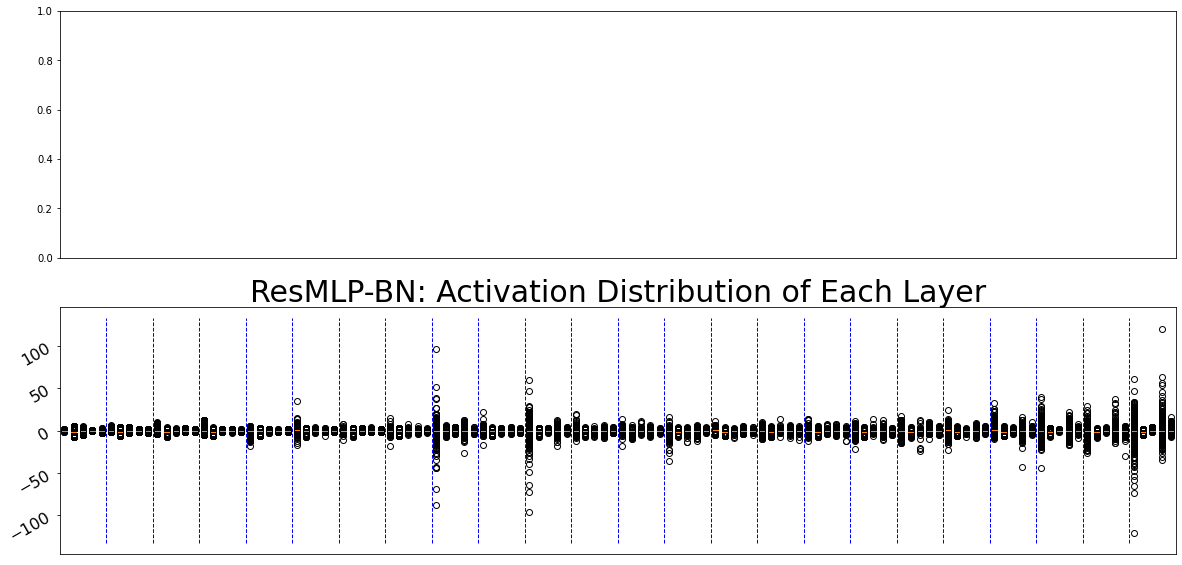

In [4]:
# model_norm = resmlp_24_norm(pretrained=True).cuda().eval()
# model_norm.cuda().eval()
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

act_dist(model_norm, 0, 23, name='ResMLP-BN: Activation Distribution of Each Layer', ax=ax[1], real_sim=False)

Creating hooks...
Loading a small piece of training data...
Calibrating...
Calibrate: [ 0/21]	Time  9.169 ( 9.169)
Calibrate: [10/21]	Time  0.205 ( 1.028)
Calibrate: [20/21]	Time  0.217 ( 0.640)
Removing hooks...


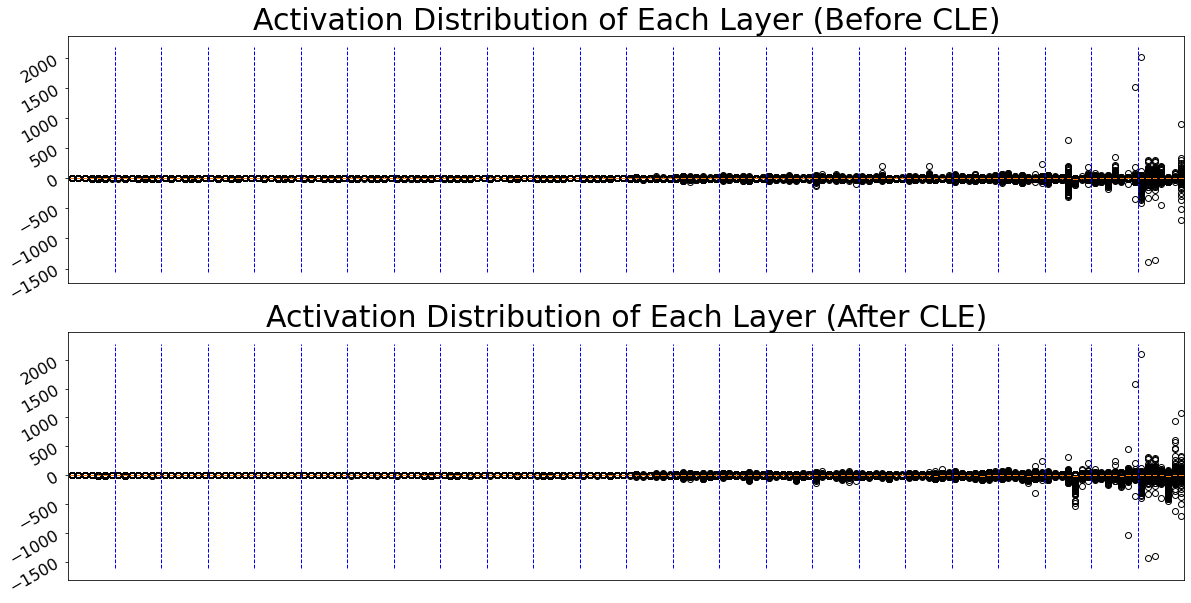

In [8]:
model = resmlp_24(pretrained=True).eval()
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

act_dist(model, 0, 23, name='Activation Distribution of Each Layer (Before CLE)', ax=ax[0])
cle_for_resmlp(model)
ba_for_resmlp(model.cuda())
# q_model = q_resmlp(model)
act_dist(model.cpu(), 0, 23, name='Activation Distribution of Each Layer (After CLE)', ax=ax[1])

Creating hooks...
Loading a small piece of training data...
Calibrating...
Calibrate: [ 0/41]	Time  8.879 ( 8.879)
Calibrate: [10/41]	Time  0.303 ( 1.104)
Calibrate: [20/41]	Time  0.360 ( 0.732)
Calibrate: [30/41]	Time  0.367 ( 0.618)
Calibrate: [40/41]	Time  0.040 ( 0.549)
Removing hooks...


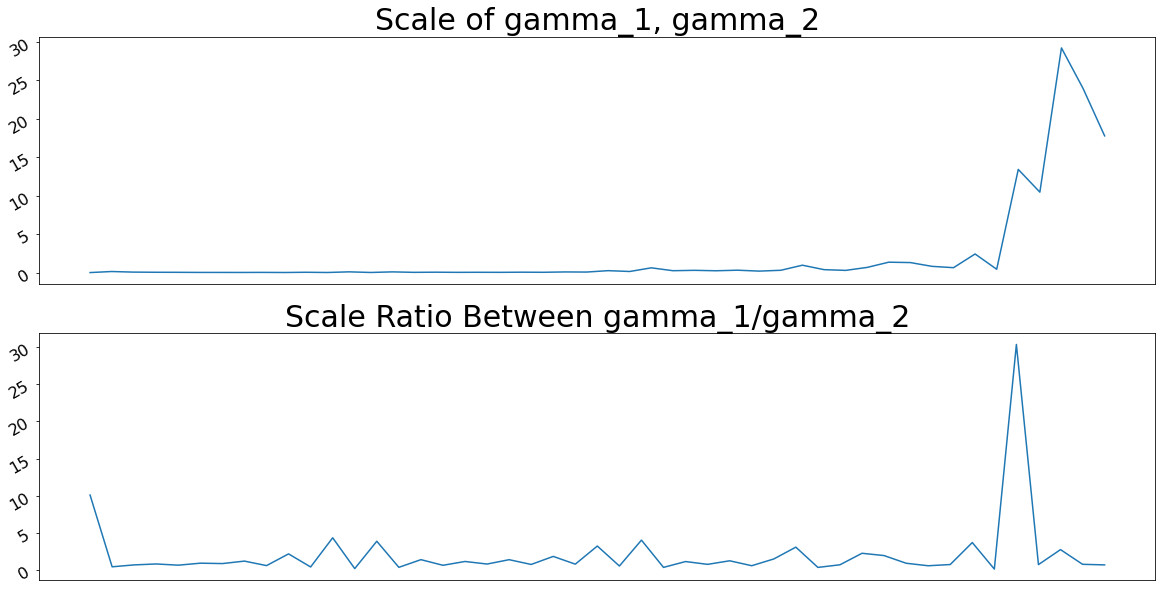

In [14]:
model = resmlp_24(pretrained=True).eval()
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

labels, data = scale_plot(model.cuda(), 0, 23, show_layers=["gamma_1", "gamma_2"], name='Scale of gamma_1, gamma_2', ax=ax[0])



In [9]:
CHECKPOINT_PATH = "input8-conv-res16-act8.pth.tar"

model = resmlp_24()
qmodel = q_resmlp(model)
qmodel.load_state_dict(torch.load(CHECKPOINT_PATH)['state_dict'])

for n, m in qmodel.named_modules():
    if isinstance(m, QLinear):
        print(n)

FileNotFoundError: [Errno 2] No such file or directory: 'input8-conv-res16-act8.pth.tar'

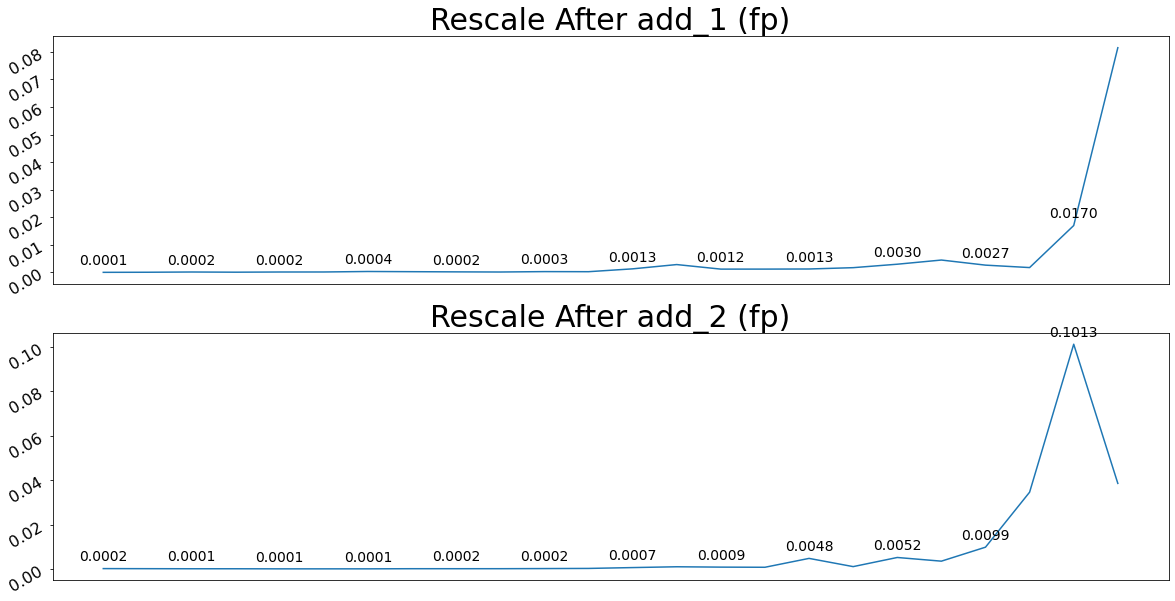

In [39]:
model = resmlp_24(pretrained=False).eval()
qmodel = q_resmlp(model)
qmodel.load_state_dict(torch.load(CHECKPOINT_PATH)['state_dict'])
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

label_1 = []
data_1 = []
for n, m in qmodel.blocks.named_modules():
    if "add_1.observer" in n:
        label_1.append(n)
        data_1.append([m.scale.item()])

ax[0].set_title('Rescale After add_1 (fp)', size=30)
ax[0].tick_params(labelrotation=30)
for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()):
    label.set_fontsize(16)
ax[0].plot(label_1, data_1)
add_value_labels(ax[0], skip_cnt=2, precision=4)

label_2 = []
data_2 = []
for n, m in qmodel.named_modules():
    if "add_2.observer" in n:
        label_2.append(n)
        data_2.append(m.scale.item())

ax[1].set_title('Rescale After add_2 (fp)', size=30)
ax[1].tick_params(labelrotation=30)
for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()):
    label.set_fontsize(16)
ax[1].plot(label_2, data_2)
add_value_labels(ax[1], skip_cnt=2, precision=4)

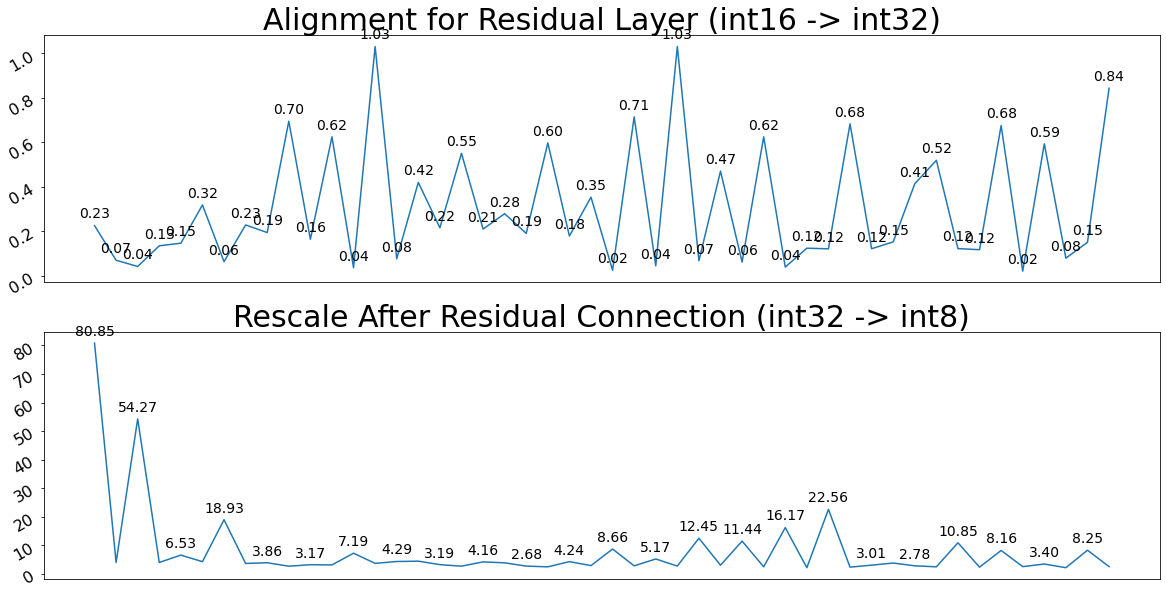

In [40]:
model = resmlp_24(pretrained=False).eval()
qmodel = q_resmlp(model)
qmodel.load_state_dict(torch.load(CHECKPOINT_PATH)['state_dict'])
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

label_1 = []
data_1 = []
for n, m in qmodel.blocks.named_modules():
    if "add" in n and "observer" not in n:
        label_1.append(n)
        scale = (m.res_mult[0].type(torch.double) / (2.0 ** m.res_shift[0]).type(torch.double)).type(torch.float)
        data_1.append(scale)

ax[0].set_title('Alignment for Residual Layer (int16 -> int32)', size=30)
ax[0].tick_params(labelrotation=30)
for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()):
    label.set_fontsize(16)
ax[0].plot(label_1, data_1)
add_value_labels(ax[0], skip_cnt=1, precision=2)


label_2 = []
data_2 = []
for n, m in qmodel.named_modules():
    if "add" in n and "observer" not in n:
        label_2.append(n)
        scale = (m.mult[0].type(torch.double) / (2.0 ** m.shift[0]).type(torch.double)).type(torch.float)
        data_2.append(scale)

ax[1].set_title('Rescale After Residual Connection (int32 -> int8)', size=30)
ax[1].tick_params(labelrotation=30)
for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()):
    label.set_fontsize(16)
ax[1].plot(label_2, data_2)
add_value_labels(ax[1], skip_cnt=2, precision=2)

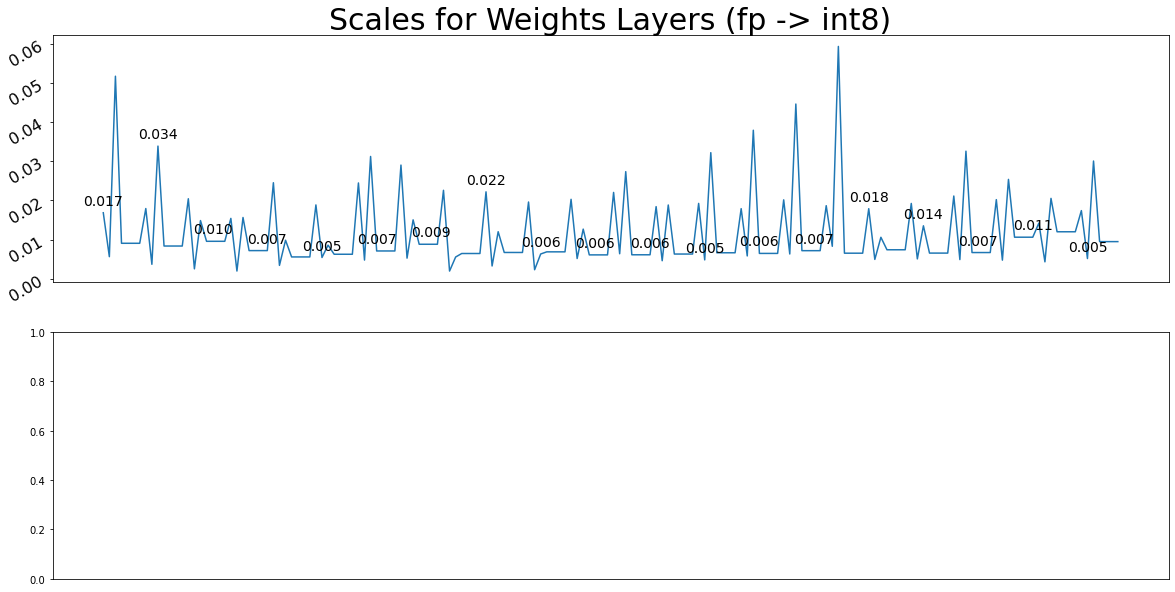

In [55]:
model = resmlp_24(pretrained=False).eval()
qmodel = q_resmlp(model)
qmodel.load_state_dict(torch.load(CHECKPOINT_PATH)['state_dict'])
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].get_xaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)

label_1 = []
data_1 = []
for n, m in qmodel.named_modules():
    if isinstance(m, QLinear):
        label_1.append(n)
        data_1.append(m.observer.scale.item())

ax[0].set_title('Scales for Weights Layers (fp -> int8)', size=30)
ax[0].tick_params(labelrotation=30)
for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()):
    label.set_fontsize(16)
ax[0].plot(label_1, data_1)
add_value_labels(ax[0], skip_cnt=9, precision=3)


# label_2 = []
# data_2 = []
# for n, m in qmodel.named_modules():
#     if "add" in n and "observer" not in n:
#         label_2.append(n)
#         scale = (m.mult[0].type(torch.double) / (2.0 ** m.shift[0]).type(torch.double)).type(torch.float)
#         data_2.append(scale)

# ax[1].set_title('Rescale After Residual Connection (int32 -> int8)', size=30)
# ax[1].tick_params(labelrotation=30)
# for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()):
#     label.set_fontsize(16)
# ax[1].plot(label_2, data_2)
# add_value_labels(ax[1], skip_cnt=2, precision=2)